In [1]:
import sys
sys.path.insert(0, '/home/cameron/Projects/hypso-package')

## Read NetCDF File

In [2]:
# Import Satellite Object
from hypso import Hypso1
import os

# Define HYPSO Image File and the .points from QGIS (if available)
dir_path = '/home/cameron/Dokumenter/Data/frohavet'
l1a_nc_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-l1a.nc')
points_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-bin3.points')

# Create Satellite Object
satobj = Hypso1(path=l1a_nc_file, points_path=points_file, verbose=True)

[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632


## Get L1A SatPy scene

In [3]:
l1a_scene = satobj.get_l1a_satpy_scene()

## Generate L1B datacube

In [4]:
satobj.generate_l1b_cube()

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...


## Get L1B datacube

In [5]:
l1b_scene = satobj.get_l1b_satpy_scene()

## Generate chlorophyll estimates

In [6]:
satobj.generate_chlorophyll_estimates('band_ratio')

[INFO] Running band ratio chlorophyll estimation...
[INFO] Calibration has already been run. Skipping.


## Get chlorophyll estimates SatPy scene

In [7]:
chl_scene = satobj.get_chlorophyll_estimates_satpy_scene()

## Create RGB composite from L1A cube

In [8]:
import satpy
from satpy.composites import GenericCompositor
from satpy.writers import to_image

# RGB Hypso image
compositor = GenericCompositor("rgb")

#R:630nm, G:550nm, B:480nm
# Red, Green, Blue, Alpha
red_wl = 630
green_wl = 550
blue_wl = 480

red_idx = satobj.get_closest_wavelength_index(red_wl)
green_idx = satobj.get_closest_wavelength_index(green_wl)
blue_idx = satobj.get_closest_wavelength_index(blue_wl)

red_band = 'band_' + str(red_idx)
green_band = 'band_' + str(green_idx)
blue_band = 'band_' + str(blue_idx)
alpha_band = 'band_' + str(blue_idx)

composite = compositor([l1a_scene[red_band][:,::3], 
                        l1a_scene[green_band][:,::3], 
                        l1a_scene[blue_band][:,::3], 
                        l1a_scene[alpha_band][:,::3]]) 

rgb_img = to_image(composite) 
rgb_img.stretch_linear()
rgb_img.gamma(1.7)

rgb_xr_image = rgb_img

rgb_img = rgb_img.pil_image()

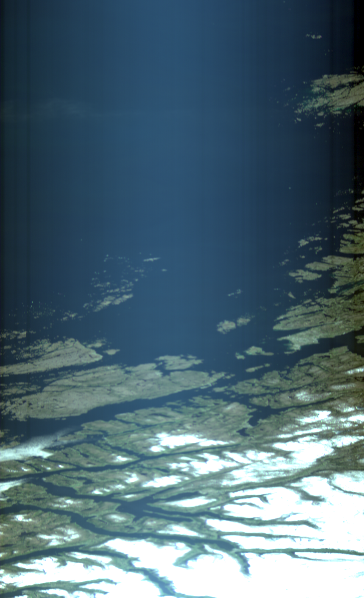

In [9]:
rgb_img

## Save RGB image

In [10]:
rgb_img.save('./' + satobj.capture_name + '_rgb.png')

## Load area definition

In [11]:
from pyresample import load_area
area_def = load_area("./frohavet_demo.yaml")

## Resample capture to area defintion

In [25]:
import numpy as np

resampled_l1a_scene = l1a_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)
resampled_chl_scene = chl_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

## Create resampled RGB composite from L1A cube

In [13]:
import satpy
from satpy.composites import GenericCompositor
from satpy.writers import to_image

# RGB Hypso image
compositor = GenericCompositor("rgb")

#R:630nm, G:550nm, B:480nm
# Red, Green, Blue, Alpha
red_wl = 630
green_wl = 550
blue_wl = 480

red_idx = satobj.get_closest_wavelength_index(red_wl)
green_idx = satobj.get_closest_wavelength_index(green_wl)
blue_idx = satobj.get_closest_wavelength_index(blue_wl)

red_band = 'band_' + str(red_idx)
green_band = 'band_' + str(green_idx)
blue_band = 'band_' + str(blue_idx)
alpha_band = 'band_' + str(blue_idx)

composite = compositor([resampled_l1a_scene[red_band], 
                        resampled_l1a_scene[green_band], 
                        resampled_l1a_scene[blue_band], 
                        resampled_l1a_scene[alpha_band]]) 

rgb_img = to_image(composite) 
rgb_img.stretch_linear()
rgb_img.gamma(1.2)

rgb_xr_image = rgb_img

rgb_img = rgb_img.pil_image()

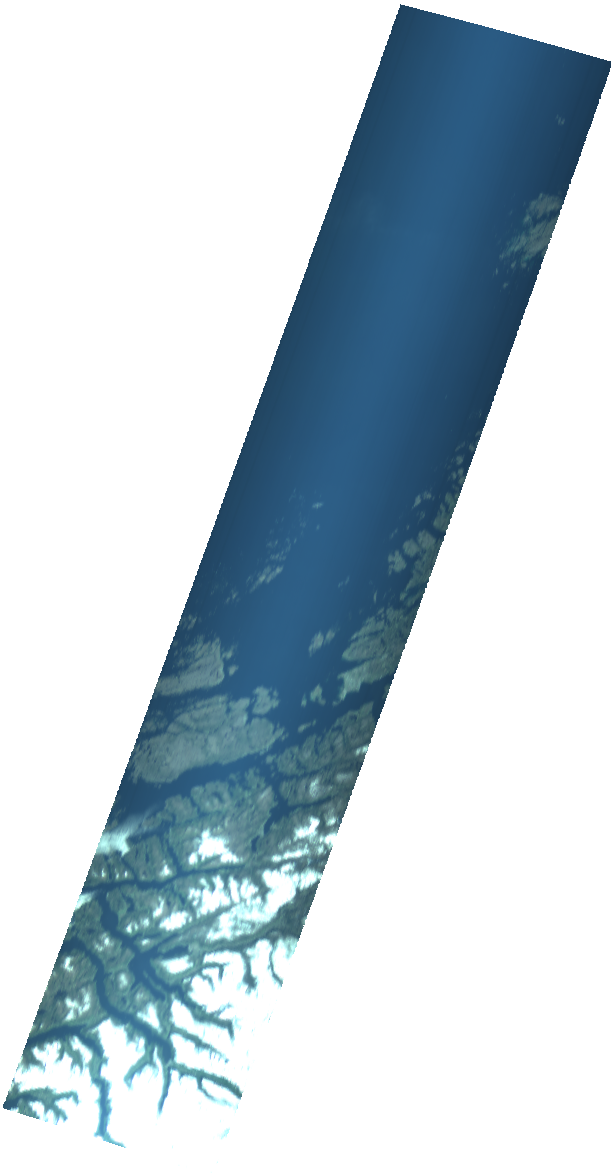

In [14]:
rgb_img

## Save resampled RGB image

In [49]:
rgb_img.save('./' + satobj.capture_name + '_rgb_resampled.png')

## Create background for RGB

In [18]:
from PIL import Image
from pycoast import ContourWriterAGG

size = (area_def.shape[1], area_def.shape[0])

# Base image
base_img = Image.new(mode="RGBA", size=size, color=(173, 216, 230))
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(base_img, area_def, resolution='f', outline='black', fill='gray')

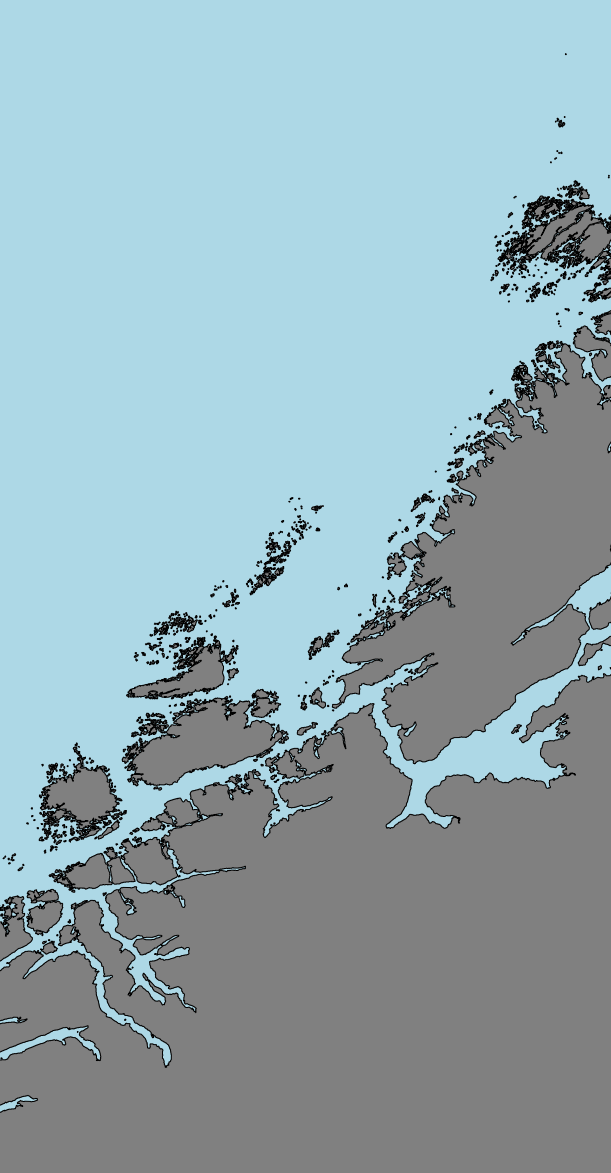

In [19]:
base_img

## Create coastlines and borders for RGB

In [21]:
# Overlay image
overlay_img = Image.new(mode="RGBA", size=size)
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(overlay_img, area_def, resolution='f', outline='black', level=4)
cw.add_rivers(overlay_img, area_def, level=10, outline='blue', resolution='f')
cw.add_borders(overlay_img, area_def, outline=(255, 0, 0))

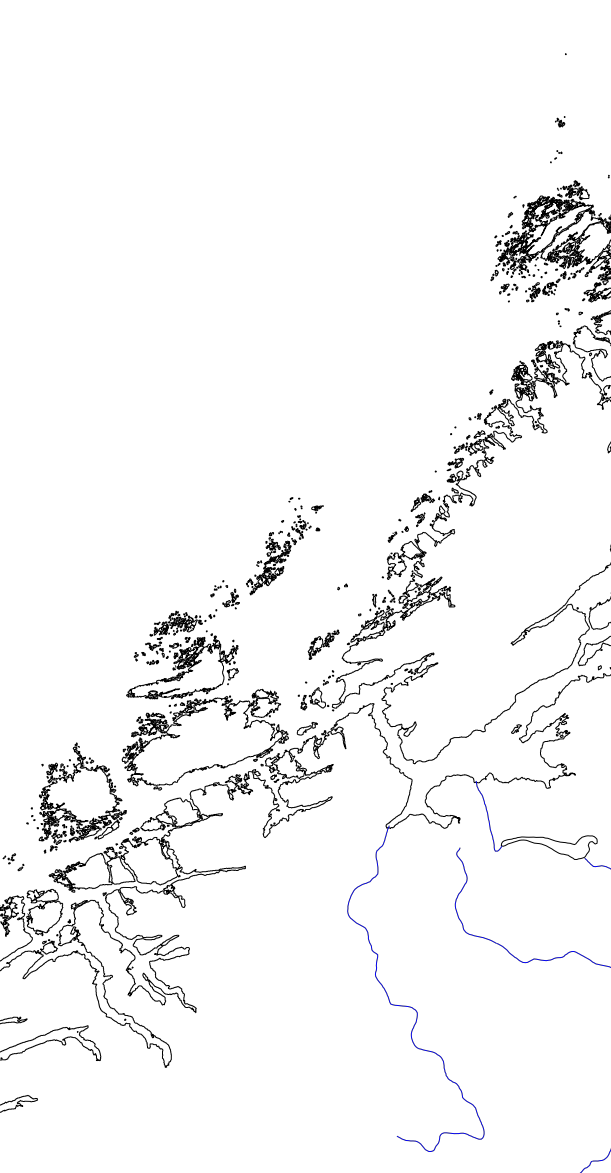

In [23]:
overlay_img

## Create an outline of the capture for RGB

In [22]:
from pyresample.geometry import SwathDefinition

swath_def = SwathDefinition(lons=satobj.longitudes, lats=satobj.latitudes)

boundary_lats, boundary_lons = swath_def.get_boundary_lonlats()

side1 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side1, boundary_lons.side1))
side2 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side2, boundary_lons.side2))
side3 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side3, boundary_lons.side3))
side4 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side4, boundary_lons.side4))

polygon_coords = side1 + side2 + side3 + side4

# Overlay image
boundary_img = Image.new(mode="RGBA", size=size)
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_polygon(boundary_img, area_def, polygon_coords, outline='red', width=3)

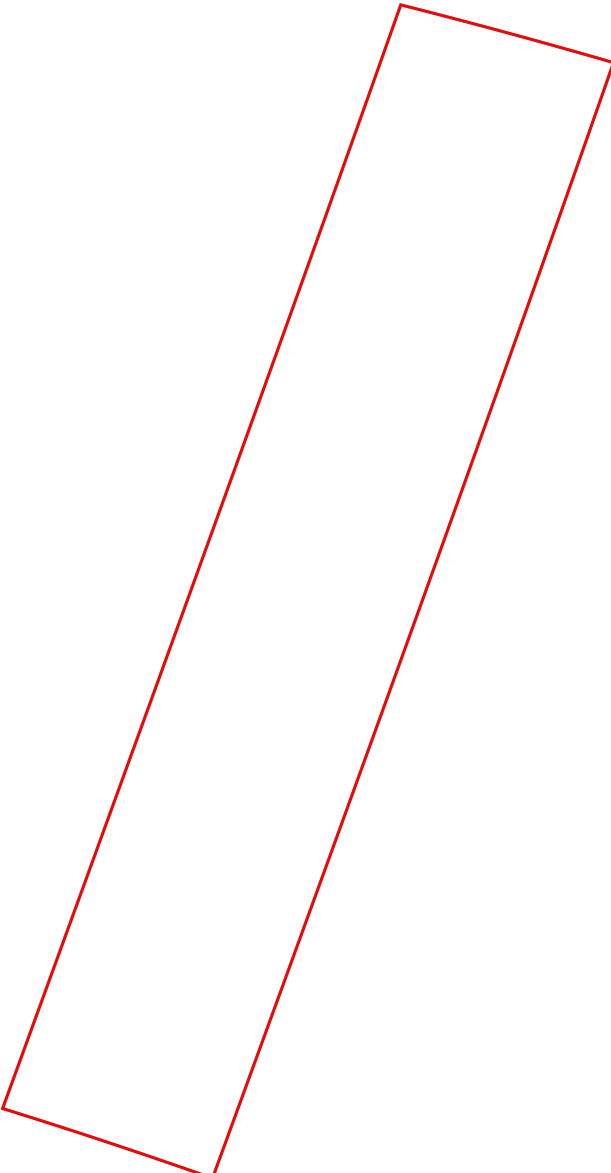

In [24]:
boundary_img

## Assemble the decorated RGB image

In [28]:
combined_img = Image.alpha_composite(base_img, rgb_img)
combined_img = Image.alpha_composite(combined_img, boundary_img)
combined_img = Image.alpha_composite(combined_img, overlay_img)
combined_img.save('./' + satobj.capture_name + '_rgb_decorated.png')

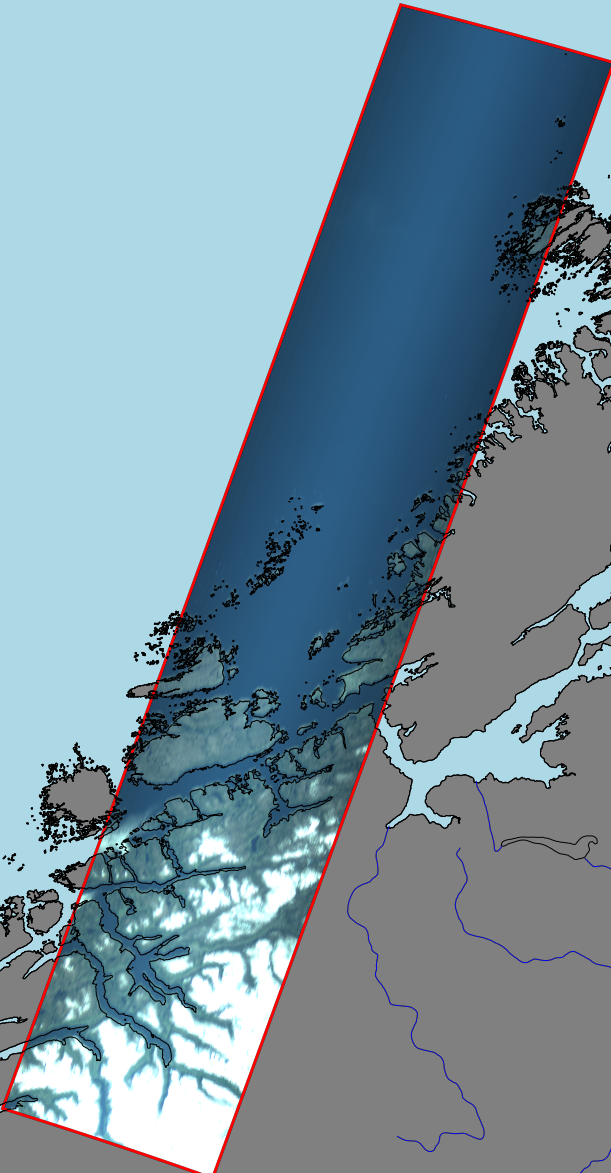

In [27]:
combined_img